<a href="https://colab.research.google.com/github/MilianAlba/DMML2_CA/blob/main/DMML2_project_segmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
import cv2
import numpy as np
from re import sub
import tensorflow as tf
from tensorflow.keras import metrics

import matplotlib.colors as mcolors

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image_dataset_from_directory

print("Done importing packages!")

Done importing packages!


In [2]:
BATCH_SIZE = 32
IMG_SIZE = (240, 240)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#data_dir = "../input/plantvillage-dataset/color"
#data_dir = "/content/drive/MyDrive/segmented_pepper/"
data_dir = "segmented"
train_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "training",
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "validation",
                                             image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory('testplantdoc',
                                             label_mode = 'categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

test_dataset_indoor = image_dataset_from_directory('plantville_test',
                                             label_mode = 'categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 20105 files belonging to 13 classes.
Using 16084 files for training.
Found 20105 files belonging to 13 classes.
Using 4021 files for validation.
Found 120 files belonging to 13 classes.
Found 4026 files belonging to 13 classes.


In [4]:
class_names = train_dataset.class_names
num_classes = len(class_names)
for i in range(1, num_classes + 1):
    print(str(i) + ". ", class_names[i - 1])

1.  Apple___Apple_scab
2.  Apple___Cedar_apple_rust
3.  Apple___healthy
4.  Pepper,_bell___Bacterial_spot
5.  Pepper,_bell___healthy
6.  Tomato___Bacterial_spot
7.  Tomato___Early_blight
8.  Tomato___Late_blight
9.  Tomato___Leaf_Mold
10.  Tomato___Septoria_leaf_spot
11.  Tomato___Tomato_Yellow_Leaf_Curl_Virus
12.  Tomato___Tomato_mosaic_virus
13.  Tomato___healthy


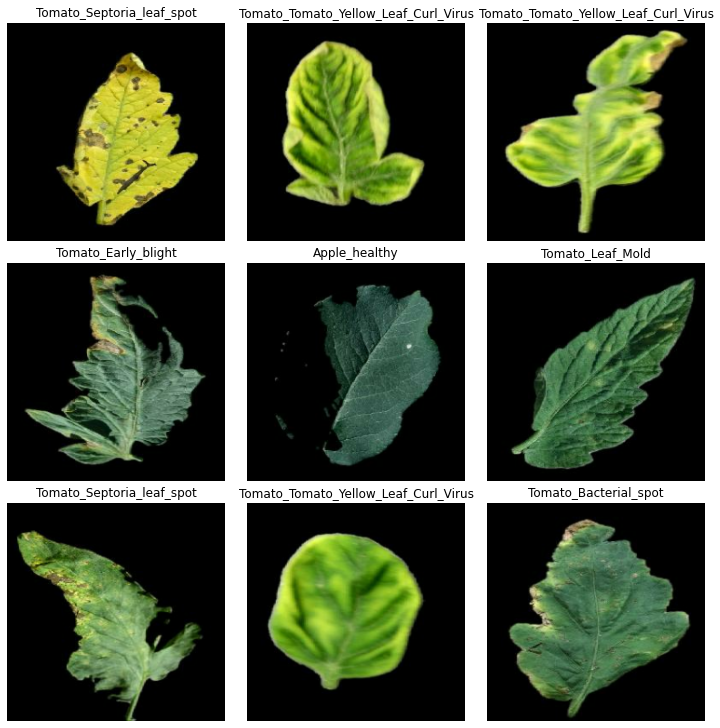

In [5]:
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = sub(r"[_]+","_",class_names[np.argmax(labels[i])])
        plt.title(title)
        plt.axis("off")

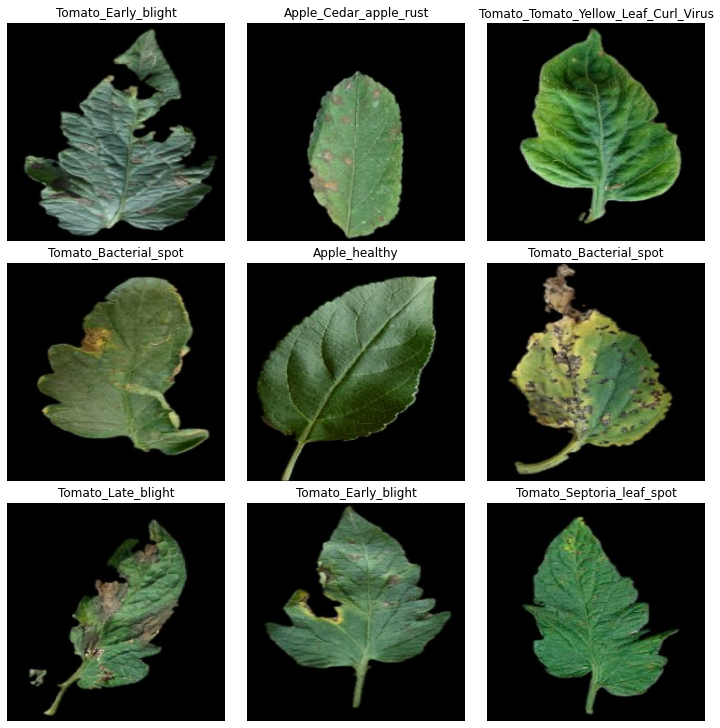

In [7]:
plt.figure(figsize=(10, 10), constrained_layout=True)
for images, labels in validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = sub(r"[_]+","_",class_names[np.argmax(labels[i])])
        plt.title(title)
        plt.axis("off")

In [8]:
#val_batches = tf.data.experimental.cardinality(validation_dataset)
#test_batches_outdoor = tf.data.experimental.cardinality(test_dataset_outdoor)

#test_dataset = validation_dataset.take(val_batches // 5)
#validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 126
Number of test batches: 4


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset_indoor = test_dataset_indoor.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  tf.keras.layers.experimental.preprocessing.RandomCrop(200, 200),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(factor=0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(factor=0.2),
  tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.4),
  #tf.keras.layers.experimental.preprocessing.Resizing(50, 50),
  #tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255),

])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


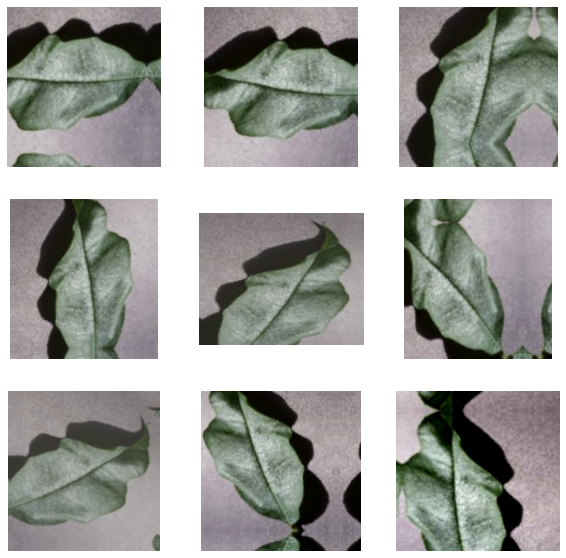

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
augmented_image

<tf.Tensor: shape=(1, 201, 205, 3), dtype=float32, numpy=
array([[[[209.77948 , 196.97498 , 203.67    ],
         [210.1924  , 197.3879  , 204.08292 ],
         [212.59991 , 199.79541 , 206.49043 ],
         ...,
         [122.633835, 107.03395 , 115.12666 ],
         [127.74944 , 112.14955 , 120.24226 ],
         [131.82639 , 116.22649 , 124.3192  ]],

        [[210.44354 , 197.639   , 204.33403 ],
         [210.45598 , 197.65149 , 204.3465  ],
         [213.29988 , 200.49539 , 207.19038 ],
         ...,
         [129.66951 , 114.069626, 122.16234 ],
         [132.58665 , 116.98674 , 125.07945 ],
         [134.19939 , 118.59951 , 126.69223 ]],

        [[210.6824  , 197.8779  , 204.57292 ],
         [211.3768  , 198.57228 , 205.2673  ],
         [213.33214 , 200.52765 , 207.22269 ],
         ...,
         [133.30045 , 117.700554, 125.79326 ],
         [131.56972 , 115.96986 , 124.06256 ],
         [132.42398 , 116.82411 , 124.916824]],

        ...,

        [[187.20589 , 173.0037  , 

In [ ]:
first_image

<tf.Tensor: shape=(240, 240, 3), dtype=float32, numpy=
array([[[130.9789  , 119.97888 , 123.97888 ],
        [ 97.933334,  86.933334,  90.933334],
        [115.05556 , 104.05556 , 108.05556 ],
        ...,
        [143.76114 , 134.76114 , 139.76114 ],
        [141.51997 , 132.51997 , 137.51997 ],
        [129.69768 , 120.69768 , 125.69768 ]],

       [[132.56667 , 121.56666 , 125.566666],
        [109.76    ,  98.76    , 102.76    ],
        [100.98334 ,  89.98334 ,  93.98334 ],
        ...,
        [145.98337 , 136.98337 , 141.98337 ],
        [147.67001 , 138.67001 , 143.67001 ],
        [138.51993 , 129.51993 , 134.51993 ]],

       [[104.77778 ,  93.77778 ,  97.77778 ],
        [106.05    ,  95.05    ,  99.05    ],
        [ 92.5     ,  81.5     ,  85.5     ],
        ...,
        [139.88893 , 130.88893 , 135.88893 ],
        [144.40004 , 135.40004 , 140.40004 ],
        [139.51662 , 130.51662 , 135.51662 ]],

       ...,

       [[118.689064, 111.689064, 119.689064],
        [108.

In [10]:
def plot_metrics(history):
  colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
  metrics = ['loss', 'auc', 'precision', 'recall']
  plt.figure(figsize=(20,10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [11]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc')
]

In [12]:
IMG_SHAPE = IMG_SIZE + (3,)

In [13]:
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

In [14]:
# base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')
base_model = tf.keras.applications.InceptionResNetV2(
                                include_top=False,
                                weights="imagenet",
                                input_shape=IMG_SHAPE,
                            )

219055592/219055592 [==============================] - 3s 0us/step


In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1536)


In [16]:
base_model.trainable = False

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

(32, 1536)


In [18]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 13)


In [19]:
inputs = tf.keras.Input(shape=(240, 240, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
print(inputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 240, 240, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [21]:
print(outputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), name='dense/Softmax:0', description="created by layer 'dense'")


In [22]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 240, 240, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 240, 240, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                      

In [24]:
len(model.trainable_variables)

2

In [25]:
initial_epochs = 10

In [26]:
len(train_dataset)

503

In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


/usr/local/lib/python3.9/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


503/503 [==============================] - 260s 490ms/step - loss: 1.0259 - tp: 7887.0000 - fp: 939.0000 - tn: 192069.0000 - fn: 8197.0000 - accuracy: 0.6842 - precision: 0.8936 - recall: 0.4904 - auc: 0.9561 - val_loss: 0.6280 - val_tp: 2749.0000 - val_fp: 222.0000 - val_tn: 48030.0000 - val_fn: 1272.0000 - val_accuracy: 0.8020 - val_precision: 0.9253 - val_recall: 0.6837 - val_auc: 0.9860
Epoch 2/10
503/503 [==============================] - 241s 479ms/step - loss: 0.5794 - tp: 11457.0000 - fp: 1066.0000 - tn: 191942.0000 - fn: 4627.0000 - accuracy: 0.8221 - precision: 0.9149 - recall: 0.7123 - auc: 0.9872 - val_loss: 0.4719 - val_tp: 3060.0000 - val_fp: 231.0000 - val_tn: 48021.0000 - val_fn: 961.0000 - val_accuracy: 0.8555 - val_precision: 0.9298 - val_recall: 0.7610 - val_auc: 0.9922
Epoch 3/10
503/503 [==============================] - 239s 476ms/step - loss: 0.4661 - tp: 12480.0000 - fp: 1060.0000 - tn: 191948.0000 - fn: 3604.0000 - accuracy: 0.8530 - precision: 0.9217 - recall:

In [28]:
epochs = list(range (1,11))
history_df = pd.DataFrame(history.history)
history_df['epochs'] = epochs
history_df['stage'] = 'first_raining'
print(history_df)

       loss       tp      fp        tn      fn  accuracy  precision    recall  \
0  1.025853   7887.0   939.0  192069.0  8197.0  0.684158   0.893610  0.490363   
1  0.579447  11457.0  1066.0  191942.0  4627.0  0.822059   0.914877  0.712323   
2  0.466114  12480.0  1060.0  191948.0  3604.0  0.853022   0.921713  0.775926   
3  0.406324  12978.0  1018.0  191990.0  3106.0  0.872047   0.927265  0.806889   
4  0.367779  13361.0  1026.0  191982.0  2723.0  0.882119   0.928686  0.830701   
5  0.345416  13596.0   998.0  192010.0  2488.0  0.892004   0.931616  0.845312   
6  0.326127  13728.0   980.0  192028.0  2356.0  0.893621   0.933370  0.853519   
7  0.309209  13859.0   973.0  192035.0  2225.0  0.899154   0.934399  0.861664   
8  0.298952  13915.0  1019.0  191989.0  2169.0  0.900087   0.931766  0.865146   
9  0.284326  14022.0   963.0  192045.0  2062.0  0.905683   0.935736  0.871798   

        auc  val_loss  val_tp  val_fp   val_tn  val_fn  val_accuracy  \
0  0.956129  0.628013  2749.0   222.

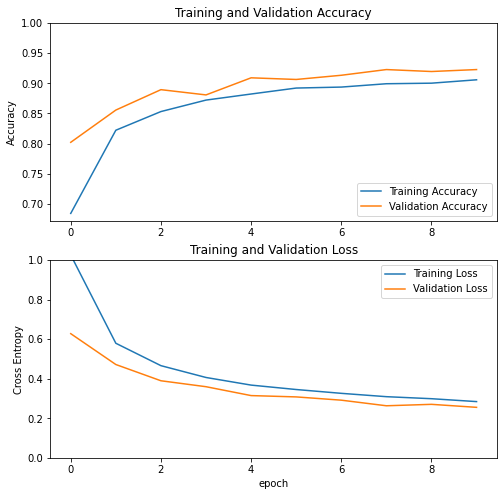

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

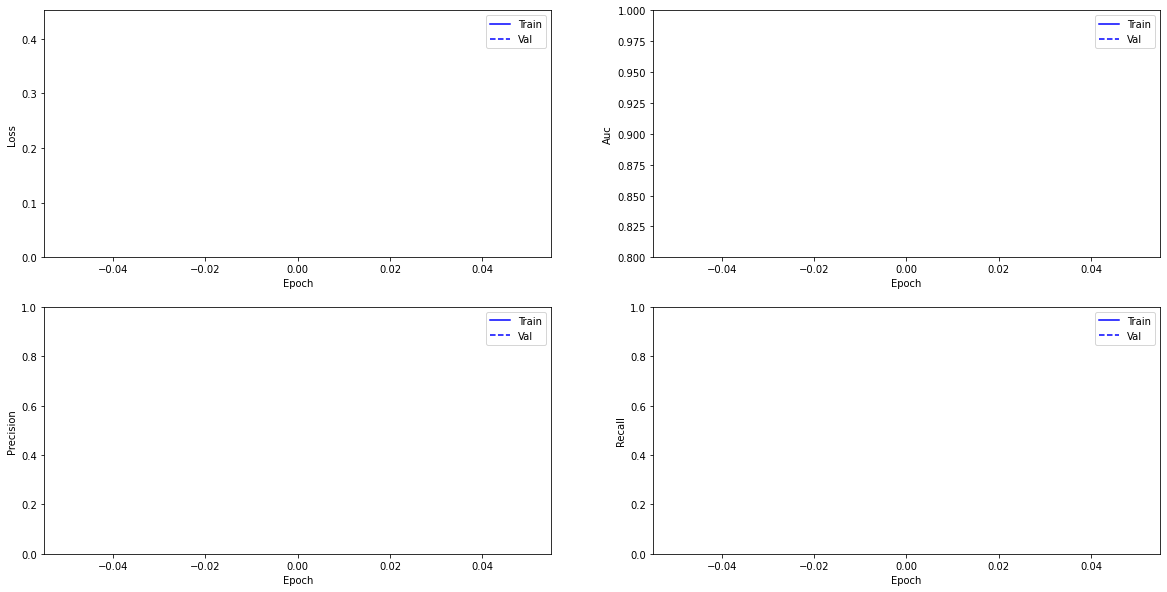

In [ ]:
plot_metrics(history)

In [30]:
base_model.trainable = True

In [31]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 700

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  780


In [32]:
fine_tuning_learning_rate = 1e-5
model.compile(optimizer=tf.keras.optimizers.Adam(lr=fine_tuning_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [33]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 240, 240, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 240, 240, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                      

In [34]:
len(model.trainable_variables)

52

In [35]:
#fine_tune_epochs = 15
fine_tune_epochs = 2
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/12


/usr/local/lib/python3.9/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


503/503 [==============================] - 295s 550ms/step - loss: 0.2055 - tp: 18300.0000 - fp: 1019.0000 - tn: 240241.0000 - fn: 1805.0000 - accuracy: 0.9280 - precision: 0.9473 - recall: 0.9102 - auc: 0.9975 - val_loss: 0.1524 - val_tp: 3789.0000 - val_fp: 152.0000 - val_tn: 48100.0000 - val_fn: 232.0000 - val_accuracy: 0.9518 - val_precision: 0.9614 - val_recall: 0.9423 - val_auc: 0.9983
Epoch 11/12
503/503 [==============================] - 272s 540ms/step - loss: 0.1283 - tp: 15269.0000 - fp: 557.0000 - tn: 192451.0000 - fn: 815.0000 - accuracy: 0.9560 - precision: 0.9648 - recall: 0.9493 - auc: 0.9992 - val_loss: 0.1281 - val_tp: 3827.0000 - val_fp: 144.0000 - val_tn: 48108.0000 - val_fn: 194.0000 - val_accuracy: 0.9590 - val_precision: 0.9637 - val_recall: 0.9518 - val_auc: 0.9987
Epoch 12/12
503/503 [==============================] - 306s 608ms/step - loss: 0.0877 - tp: 15523.0000 - fp: 389.0000 - tn: 192619.0000 - fn: 561.0000 - accuracy: 0.9698 - precision: 0.9756 - recall: 

In [37]:
epochst = list(range (11,14))
historyfinetune_df = pd.DataFrame(history_fine.history)
historyfinetune_df['epochs'] = epochst
historyfinetune_df['stage'] = 'fine_tune'
print(historyfinetune_df)

       loss       tp      fp        tn      fn  accuracy  precision    recall  \
0  0.205477  18300.0  1019.0  240241.0  1805.0  0.928028   0.947254  0.910221   
1  0.128303  15269.0   557.0  192451.0   815.0  0.955981   0.964805  0.949329   
2  0.087716  15523.0   389.0  192619.0   561.0  0.969784   0.975553  0.965121   

        auc  val_loss  val_tp  val_fp   val_tn  val_fn  val_accuracy  \
0  0.997494  0.152429  3789.0   152.0  48100.0   232.0      0.951753   
1  0.999185  0.128107  3827.0   144.0  48108.0   194.0      0.958965   
2  0.999585  0.107109  3864.0   117.0  48135.0   157.0      0.966178   

   val_precision  val_recall   val_auc  epochs      stage  
0       0.961431    0.942303  0.998259      11  fine_tune  
1       0.963737    0.951753  0.998748      12  fine_tune  
2       0.970610    0.960955  0.998605      13  fine_tune  


In [38]:
ht_df = pd.concat([history_df, historyfinetune_df], axis=0, ignore_index=True)
print(ht_df)

        loss       tp      fp        tn      fn  accuracy  precision  \
0   1.025853   7887.0   939.0  192069.0  8197.0  0.684158   0.893610   
1   0.579447  11457.0  1066.0  191942.0  4627.0  0.822059   0.914877   
2   0.466114  12480.0  1060.0  191948.0  3604.0  0.853022   0.921713   
3   0.406324  12978.0  1018.0  191990.0  3106.0  0.872047   0.927265   
4   0.367779  13361.0  1026.0  191982.0  2723.0  0.882119   0.928686   
5   0.345416  13596.0   998.0  192010.0  2488.0  0.892004   0.931616   
6   0.326127  13728.0   980.0  192028.0  2356.0  0.893621   0.933370   
7   0.309209  13859.0   973.0  192035.0  2225.0  0.899154   0.934399   
8   0.298952  13915.0  1019.0  191989.0  2169.0  0.900087   0.931766   
9   0.284326  14022.0   963.0  192045.0  2062.0  0.905683   0.935736   
10  0.205477  18300.0  1019.0  240241.0  1805.0  0.928028   0.947254   
11  0.128303  15269.0   557.0  192451.0   815.0  0.955981   0.964805   
12  0.087716  15523.0   389.0  192619.0   561.0  0.969784   0.97

In [39]:
ht_df.to_csv('resultsSegmentedModel_13epochs.csv')

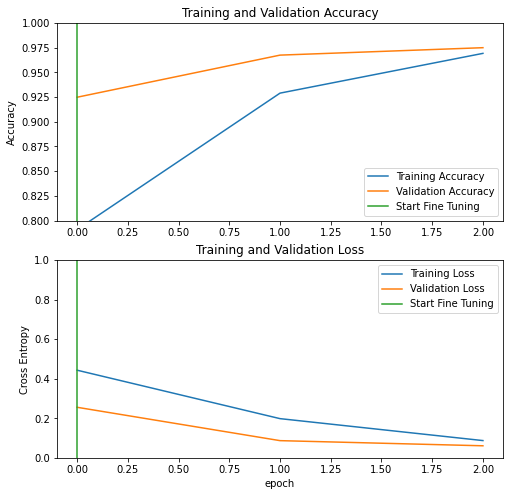

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']



plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.show()

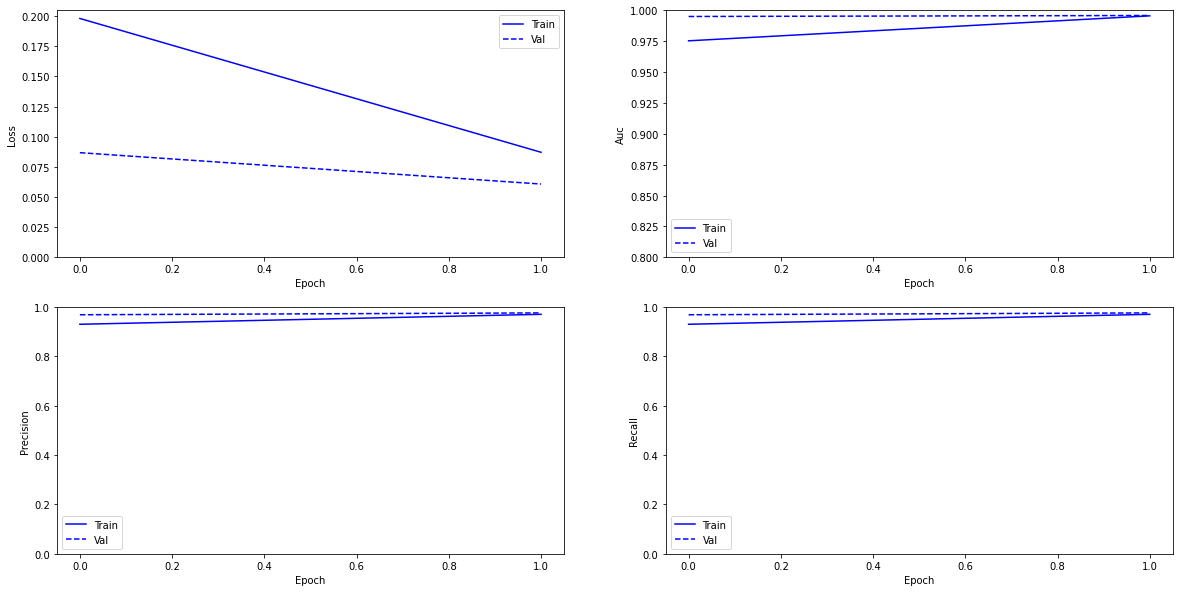

In [ ]:
plot_metrics(history_fine)

In [40]:
result = model.evaluate(test_dataset)

4/4 [==============================] - 5s 726ms/step - loss: 9.1701 - tp: 16.0000 - fp: 93.0000 - tn: 1347.0000 - fn: 104.0000 - accuracy: 0.1417 - precision: 0.1468 - recall: 0.1333 - auc: 0.5567


In [41]:
result = model.evaluate(test_dataset_indoor)

126/126 [==============================] - 51s 388ms/step - loss: 0.5628 - tp: 3299.0000 - fp: 570.0000 - tn: 47742.0000 - fn: 727.0000 - accuracy: 0.8331 - precision: 0.8527 - recall: 0.8194 - auc: 0.9815


In [ ]:
result = model.evaluate(validation_dataset)

13/13 [==============================] - 103s 8s/step - loss: 0.0609 - tp: 389.0000 - fp: 10.0000 - tn: 389.0000 - fn: 10.0000 - accuracy: 0.9749 - precision: 0.9749 - recall: 0.9749 - auc: 0.9958


In [ ]:
print(len(test_dataset))

2


In [ ]:
print(len(validation_dataset))

10


In [ ]:
print(len(train_dataset))

45


In [ ]:
metrics = ["loss", "tp", "fp", "tn", "fn", "accuracy", "precision", "recall", "auc"]
for i in range(len(result)):
    print("{} : {}".format(metrics[i],round(result[i], 3)))

loss : 0.035
tp : 288.0
fp : 5.0
tn : 3511.0
fn : 5.0
accuracy : 0.983
precision : 0.983
recall : 0.983
auc : 1.0


Predictions:
 [3, 10, 10, 10, 4, 3, 4, 3, 4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4, 10, 10, 10, 10, 10, 3, 10, 10, 3, 10, 10, 3]
Labels:
 [3, 10, 10, 10, 4, 3, 4, 3, 4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4, 10, 10, 10, 10, 10, 4, 10, 10, 3, 10, 10, 3]


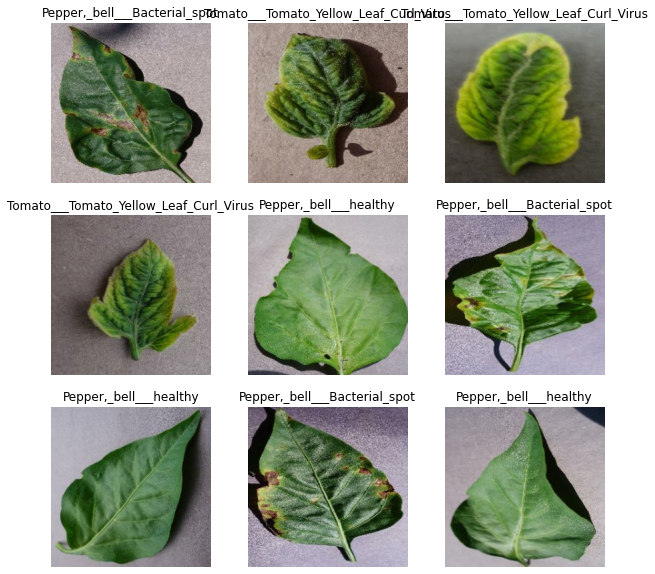

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)
predictions = list(np.argmax(x) for x in predictions.numpy())

print('Predictions:\n', predictions)
print('Labels:\n', list(np.argmax(x) for x in label_batch))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [42]:
models.save_model(model, "./inception_v3_segmented")

INFO:tensorflow:Assets written to: ./inception_v3_segmented/assets


INFO:tensorflow:Assets written to: ./inception_v3_segmented/assets
